### Speeches

#### Import

In [1]:
#pip freeze | findstr spacy
#pip uninstall -y spacy spacy-legacy spacy-loggers pydantic pydantic-core
#pip install spacy==3.7.4 pydantic==1.10.19
#!python -m spacy download en_core_web_sm

In [ ]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set tqdm to work with pandas apply
from tqdm import tqdm
tqdm.pandas()

import re
import spacy
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

c:\Users\agust\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\agust\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### All speeches

##### Speeches from EMI dataset (1879-2022)

In [3]:
##Long upload

# Load the gzip file into a DataFrame
old_speeches = pd.read_csv('US_Congressional_speeches_EMI/datasets/osfstorage-archive/speeches_filtered/combined_congress1879_till_2022_filtered_nonprocedural.csv.gzip', 
                 compression='gzip')

C:\Users\agust\AppData\Local\Temp\ipykernel_13324\856093044.py:4: DtypeWarning: Columns (0,3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  old_speeches = pd.read_csv('US_Congressional_speeches_EMI/datasets/osfstorage-archive/speeches_filtered/combined_congress1879_till_2022_filtered_nonprocedural.csv.gzip',


In [4]:
old_speeches.head(2)

,speech_id,text,speaker,bioguide_id,date,last_name,first_name,middle_name,gender,party,chamber,year
0,CREC-2015-01-02-pt1-PgE1855-2-2,"Mr. Speaker, I rise today to honor Joe W. Stri...",Mr. BOEHNER,B000589,2015-01-02,Boehner,John,A.,M,Republican,H,2015
1,CREC-2015-01-02-pt1-PgE1856-2-2,"Mr. Speaker, since before the terrorist attack...",Mr. WAXMAN,W000215,2015-01-02,Waxman,Henry,A.,M,Democrat,H,2015


Handle 2015 and 2016 duplicates

In [5]:
old_speeches = old_speeches[
    (~old_speeches["year"].isin([2015, 2016])) |
    (old_speeches["year"].isin([2015, 2016]) & old_speeches["speech_id"].str.startswith("CREC"))
]

##### Add 2023 and 2024

In [6]:
#Import and rename according to old_speeches
new_speeches = pd.read_csv('US_Congressional_speeches_EMI/crec_procflag.csv')
new_speeches.rename(columns={'speech': 'text', 'speaker_bioguide':'bioguide_id'}, inplace=True)

In [7]:
#select non-procedural
new_speeches_non_proc = new_speeches[new_speeches["procedural_flag"] == 0]

columns = ["speech_id", "text", "speaker", "bioguide_id", "date", "chamber"]
new_speeches_non_proc = new_speeches_non_proc.loc[:, columns]

In [8]:
# Create the "year" column from the first 4 characters of the "date" column
new_speeches_non_proc = new_speeches_non_proc.assign(year=new_speeches_non_proc["date"].str[:4])

In [9]:
def extract_legislator_info_from_dataframe(df, bioguide_col, data_dir="."):
    """
    Extract legislator details and fill the specified DataFrame columns from current and historical data.
    
    Args:
        df (pd.DataFrame): The DataFrame containing a column with bioguide IDs.
        bioguide_col (str): The column name in the DataFrame containing bioguide IDs.
        data_dir (str): Directory containing YAML files.
        
    Returns:
        pd.DataFrame: Updated DataFrame with legislator information.
    """
    # Files containing legislator data
    current_file = os.path.join(data_dir, "legislators-current.yaml")
    historical_file = os.path.join(data_dir, "legislators-historical.yaml")
    
    if not os.path.exists(current_file) or not os.path.exists(historical_file):
        raise FileNotFoundError("Ensure both 'legislators-current.yaml' and 'legislators-historical.yaml' are present.")
    
    # Load YAML data
    with open(current_file, "r") as file:
        current_legislators = yaml.safe_load(file)
    with open(historical_file, "r") as file:
        historical_legislators = yaml.safe_load(file)
    
    # Combine current and historical data
    all_legislators = current_legislators + historical_legislators
    
    # Create a lookup dictionary for quick access
    legislator_dict = {}
    for leg in all_legislators:
        bioguide = leg.get("id", {}).get("bioguide")
        if bioguide:
            name = leg.get("name", {})
            terms = leg.get("terms", [])
            # Safely access the 'party' key, defaulting to "Unknown" if missing
            last_party = terms[-1].get("party", "Unknown") if terms else "Unknown"
            legislator_dict[bioguide] = {
                "last_name": name.get("last"),
                "first_name": name.get("first"),
                "middle_name": name.get("middle"),
                "gender": leg.get("bio", {}).get("gender"),
                "party": last_party,
            }
    
    # Add new columns to the DataFrame
    df["last_name"] = df[bioguide_col].map(lambda x: legislator_dict.get(x, {}).get("last_name"))
    df["first_name"] = df[bioguide_col].map(lambda x: legislator_dict.get(x, {}).get("first_name"))
    df["middle_name"] = df[bioguide_col].map(lambda x: legislator_dict.get(x, {}).get("middle_name"))
    df["gender"] = df[bioguide_col].map(lambda x: legislator_dict.get(x, {}).get("gender"))
    df["party"] = df[bioguide_col].map(lambda x: legislator_dict.get(x, {}).get("party"))
    
    return df

In [10]:
# Replace with the directory containing YAML files
DATA_DIR = "US_Congressional_speeches_EMI"

# Extract legislator information
new_speeches_non_proc = extract_legislator_info_from_dataframe(new_speeches_non_proc, "bioguide_id", DATA_DIR)

In [11]:
new_speeches_non_proc.columns

Index(['speech_id', 'text', 'speaker', 'bioguide_id', 'date', 'chamber',
       'year', 'last_name', 'first_name', 'middle_name', 'gender', 'party'],
      dtype='object')

Concatenate old and new speeches

In [12]:
speeches = pd.concat([old_speeches, new_speeches_non_proc], ignore_index=True, sort=False)

In [13]:
speeches['year'] = speeches['year'].astype(int)  

In [14]:
#Save number or total speeches per year for all the dataset
total_speeches_per_year = speeches.groupby('year', group_keys=False).size()

In [15]:
with open('python_objects/total_speeches_per_year.pkl', 'wb') as f:
     pickle.dump(total_speeches_per_year, f)

#### Load yearly totals

In [3]:
total_speeches_per_year = pd.read_pickle('python_objects/total_speeches_per_year.pkl')

In [4]:
def get_total_speeches_in_span(total_speeches_per_year, start_year, end_year):
    # Filter the Series for the specified range of years and calculate the sum
    total_speeches_in_span = total_speeches_per_year[(total_speeches_per_year.index >= start_year) &
                                                     (total_speeches_per_year.index <= end_year)].sum()
    return total_speeches_in_span

In [5]:
start_year = 1939
end_year = 2024

total39_speeches = get_total_speeches_in_span(total_speeches_per_year, start_year, end_year)
print(f"Total speeches from {start_year} to {end_year}: {total39_speeches}")

start_year = 1980
total80_speeches = get_total_speeches_in_span(total_speeches_per_year, start_year, end_year)


print(f"Total speeches from {start_year} to {end_year}: {total80_speeches}")
#4.944.727

Total speeches from 1939 to 2024: 4944727
Total speeches from 1980 to 2024: 2180206


### Process the congress speeches from 1939 onwards

In [6]:
speeches_39_onward = speeches[speeches['year'] >= 1939]
print("1939:", len(speeches_39_onward))

NameError: name 'speeches' is not defined

In [37]:
speeches_39_onward["party"].value_counts(normalize=True) * 100

party
Democrat       56.713928
Republican     43.282854
Independent     0.003218
Name: proportion, dtype: float64

In [38]:
speeches_80_onward = speeches[speeches['year'] >= 1980]
print("1980:",len(speeches_80_onward))

1980: 2180206


In [39]:
speeches_80_onward["party"].value_counts(normalize=True) * 100

party
Democrat       51.912561
Republican     48.080134
Independent     0.007305
Name: proportion, dtype: float64

Graph yearly totals

Visualization for total speeches

In [8]:
# Data preparation: Filter and ensure numeric years
total_speeches_per_year = total_speeches_per_year[total_speeches_per_year.index >= 1980]
years = total_speeches_per_year.index.astype(int)

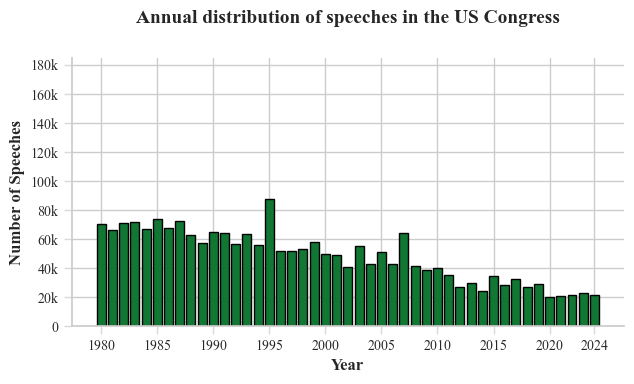

In [9]:
# Set up the plotting theme and font
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

# Create figure with size based on LaTeX's linewidth
fig_width_inch = 6.5  # Typical figure width for LaTeX
fig_height_inch = 4   # Adjust to maintain aspect ratio
plt.figure(figsize=(fig_width_inch, fig_height_inch))

# Define color for bars
bar_color = "#117733"

# Plot the data
plt.bar(years, total_speeches_per_year.values, color=bar_color, edgecolor="black", width=0.8, align="center")

# Titles and labels
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.ylabel("Number of Speeches", fontsize=12, fontweight="bold")
plt.title("Annual distribution of speeches in the US Congress", fontsize=14, fontweight="bold", pad=25)

# Set x-axis ticks every 10 years (adjust to your data range)
tick_positions = np.arange(1980, max(years) + 1, 5).tolist()  
tick_positions.append(2024)
plt.xticks(tick_positions, fontsize=12)

# Format y-axis ticks to display values in 'k' for thousands
plt.ylim(0, 185000)
plt.yticks(np.arange(0, 180001, 20000), fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x*1e-3)}k' if x >= 1000 else str(int(x))))

# Make tick marks stand out outside the axis
plt.gca().tick_params(which="both", bottom=True, left=True, length=6, width=1, color='#D9D9D9', labelsize=10)

# Remove unnecessary spines for cleaner appearance
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a high-quality PNG image
plt.savefig("annual_speeches_distribution.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


#### Extract speeches with "inequ|gap|disparit" cases

Regex test

In [ ]:
#regex test
test_pattern = r'\b(inequ|gap|disparit)\w*'

txt = "in1equalities are in the rise wages"
pd.Series([txt]).str.contains(test_pattern, 
                              case=False, 
                              na=False, 
                              regex=True)

C:\Users\agust\AppData\Local\Temp\ipykernel_29856\1800661815.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  pd.Series([txt]).str.contains(test_pattern,


0    False
dtype: bool

Reduce dataset size for more detailed token querying afterwards

In [ ]:
#pattern1_new = r'\b(inequ|gap|disparit)\w*'
pattern1 = r'\b(inequ|gap)\w*'

In [ ]:
# Filter rows where the 'text' column contains the pattern
inequality_df = speeches_39_onward[speeches_39_onward['text'].str.contains(pattern1, 
                                                                             case=False, 
                                                                             na=False, 
                                                                             regex=True)]

C:\Users\agust\AppData\Local\Temp\ipykernel_29856\2925529808.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  inequality_df = speeches_39_onward[speeches_39_onward['text'].str.contains(pattern1,


In [ ]:
#total39_speeches
print(total39_speeches)

ineq_speeches_n = len(inequality_df)
print(ineq_speeches_n)

ineq_speeches_percent = ineq_speeches_n/total39_speeches*100
print("Ineq vs. total speeches:", round(ineq_speeches_percent, 2),"%")

4944727
63330
Ineq vs. total speeches: 1.28 %


In [ ]:
inequality_df.to_csv('python_objects/congress39_ineq_2401.csv', index=False)

#### From ineq speeches extract those with economical terms

In [ ]:
inequality_df = pd.read_csv('python_objects/congress39_ineq_2401.csv')
#inequality_df = pd.read_csv('python_objects/congress39_ineq_0212_nyt_query.csv')
#inequality_df = pd.read_csv('python_objects/congress39_econ_ineq_2911_new_query.csv')

In [ ]:
# Economical terms pattern
#pattern2_new = r'\b(income|incomes|salary|salaries|wage|wages|compensation|compensations|rich|richs|poor|poors|pay|wealth)\b(?!\w)|\b(economic)\w*\b'
pattern2 = r'\b(income|salary|wage|compensation|pay|wealth|economic)\w*\b'


In [ ]:
# Filter rows where the 'text' column contains the pattern
econ_inequ_df = inequality_df[inequality_df['text'].str.contains(pattern2, 
                                                                case=False, 
                                                                na=False, 
                                                                regex=True)]

C:\Users\agust\AppData\Local\Temp\ipykernel_29856\208698655.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  econ_inequ_df = inequality_df[inequality_df['text'].str.contains(pattern2,


In [ ]:
print("Ineq speeches:",ineq_speeches_n)

econ_ineq_speeches_n = len(econ_inequ_df)
print("Econ ineq speeches:", econ_ineq_speeches_n)

print("Econ ineq vs. ineq:", round(econ_ineq_speeches_n/ineq_speeches_n*100, 2),"%")
print()

print("Ineq vs. total speeches:", round(ineq_speeches_percent, 2),"%")
econ_ineq_speeches_percent = econ_ineq_speeches_n/total39_speeches*100
print("Econ ineq vs. total speeches:", round(econ_ineq_speeches_percent, 2),"%")
print("% difference:", round(ineq_speeches_percent - econ_ineq_speeches_percent, 3),"%")

Ineq speeches: 63330
Econ ineq speeches: 39102
Econ ineq vs. ineq: 61.74 %

Ineq vs. total speeches: 1.28 %
Econ ineq vs. total speeches: 0.79 %
% difference: 0.49 %


### Tokenize for "window query"

Test tokenizer

In [ ]:
# Test text
text = "#The %quick > brown-fox jum!ps over' 34 case1 the lazy dog."

# Process the text
doc = nlp(text.lower())

print([token.text for token in doc if token.is_alpha])
print()

# Inspect tokens
for token in doc:
    print(f"Text: {token.text}, Lemma: {token.lemma_}, POS: {token.pos_}, Is stop word: {token.is_stop}")


['the', 'quick', 'brown', 'fox', 'over', 'the', 'lazy', 'dog']

Text: #, Lemma: , POS: , Is stop word: False
Text: the, Lemma: , POS: , Is stop word: True
Text: %, Lemma: , POS: , Is stop word: False
Text: quick, Lemma: , POS: , Is stop word: False
Text: >, Lemma: , POS: , Is stop word: False
Text: brown, Lemma: , POS: , Is stop word: False
Text: -, Lemma: , POS: , Is stop word: False
Text: fox, Lemma: , POS: , Is stop word: False
Text: jum!ps, Lemma: , POS: , Is stop word: False
Text: over, Lemma: , POS: , Is stop word: True
Text: ', Lemma: , POS: , Is stop word: False
Text: 34, Lemma: , POS: , Is stop word: False
Text: case1, Lemma: , POS: , Is stop word: False
Text: the, Lemma: , POS: , Is stop word: True
Text: lazy, Lemma: , POS: , Is stop word: False
Text: dog, Lemma: , POS: , Is stop word: False
Text: ., Lemma: , POS: , Is stop word: False


Clean and tokenize

In [ ]:
# Apply the function to the 'text' column
econ_inequ_df['cleaned_tokens'] = econ_inequ_df['text'].progress_apply(clean_and_tokenize_spacy)

100%|██████████| 39102/39102 [01:41<00:00, 386.73it/s]
C:\Users\agust\AppData\Local\Temp\ipykernel_29856\812643878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_inequ_df['cleaned_tokens'] = econ_inequ_df['text'].progress_apply(clean_and_tokenize_spacy)


In [ ]:
# Show the result
econ_inequ_df[['text', 'cleaned_tokens']].head()

,text,cleaned_tokens
0,"Mr. Speaker, today I have introduced the Guam ...","[Speaker, today, I, have, introduced, the, Gua..."
1,"Mr. Speaker, I thank my colleague. Mr. Speaker...","[Speaker, I, thank, my, colleague, Speaker, it..."
3,"Mr. President, today, I am pleased to reintrod...","[President, today, I, am, pleased, to, reintro..."
4,"The Senator from Colorado, Michael Bennet, and...","[The, Senator, from, Colorado, Michael, Bennet..."
5,"Mr. Speaker, today I introduced legislation to...","[Speaker, today, I, introduced, legislation, t..."


### Apply window query condition

With tokenized text create matching boolean in df

In [ ]:
# Function to check if pattern1 and pattern2 are within 5 words
def check_patterns_in_window(tokens):
    # Find positions of words matching pattern1 and pattern2
    pattern1_positions = [i for i, token in enumerate(tokens) if re.match(pattern1, token, re.IGNORECASE)]
    pattern2_positions = [i for i, token in enumerate(tokens) if re.match(pattern2, token, re.IGNORECASE)]
    
    # Check if any of the pattern1 words are within 5 words of any pattern2 word
    for p1_pos in pattern1_positions:
        for p2_pos in pattern2_positions:
            if abs(p1_pos - p2_pos) <= 5:
                return True  # Found a match within the window
    return False  # No match found within the window

In [ ]:
econ_inequ_df['pattern_match_within_window'] = econ_inequ_df['cleaned_tokens'].progress_apply(check_patterns_in_window)

100%|██████████| 39102/39102 [01:23<00:00, 467.39it/s]
C:\Users\agust\AppData\Local\Temp\ipykernel_29856\4151181999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_inequ_df['pattern_match_within_window'] = econ_inequ_df['cleaned_tokens'].progress_apply(check_patterns_in_window)


In [ ]:
econ_inequ_df["pattern_match_within_window"].sum() #5333

5270

In [ ]:
print("Ineq speeches:",ineq_speeches_n)
print("Econ ineq speeches:", econ_ineq_speeches_n)

econ_inequ_window_speeches_n = econ_inequ_df["pattern_match_within_window"].sum()
print("Econ ineq window speeches:", econ_inequ_window_speeches_n)

print("Econ ineq vs. ineq:", round(econ_ineq_speeches_n/ineq_speeches_n*100, 2),"%")
print()

print("Ineq vs. total speeches:", round(ineq_speeches_percent, 2),"%")
print()
print("Econ ineq vs. total speeches:", round(econ_ineq_speeches_percent, 2),"%")
econ_ineq_window_speeches_percent = econ_inequ_window_speeches_n/total39_speeches*100
print("Econ ineq window vs. total speeches:", round(econ_ineq_window_speeches_percent, 2),"%")

print("% difference:", round(econ_ineq_speeches_percent - econ_ineq_window_speeches_percent, 3),"%")

Ineq speeches: 63330
Econ ineq speeches: 39102
Econ ineq window speeches: 5270
Econ ineq vs. ineq: 61.74 %

Ineq vs. total speeches: 1.28 %

Econ ineq vs. total speeches: 0.79 %
Econ ineq window vs. total speeches: 0.11 %
% difference: 0.684 %


In [ ]:
econ_inequ_df.to_csv('python_objects/congress39_econ_ineq_2401.csv', index=False)

## Analyze dataset

In [ ]:
#Load econ ineq dataset
econ_inequ_df = pd.read_csv('python_objects/congress39_econ_ineq_2401.csv')

In [ ]:
mean_length = econ_inequ_df["cleaned_tokens"].apply(len).mean()
print(mean_length)

### Read examples

In [ ]:
# Sample data
window_texts = econ_inequ_df[econ_inequ_df["pattern_match_within_window"] == True]['text']
econ_texts = econ_inequ_df['text']

for i in range(130,140):
    text = window_texts.iloc[i]
    print(f"Index {i}:")

    # Search for "inequ" or "gap" and get the surrounding context (30 characters before and after)
    matches = re.finditer(r'.{0,30}(inequ|gap).{0,30}', text.lower())  # .{0,30} matches up to 30 chars before and after

    for match in matches:
        start, end = match.span()  # Get start and end of the match
        # Show 30 chars before and after, ensuring the bounds don't go out of range
        context_before = text[max(0, start - 30):start]
        context_after = text[end:end + 30]
        print(f"...{context_before}{match.group(0)}{context_after}...")


Index 130:
...men. And Latinas earn a mere 44 cents. this persistent wage gap is a reflection of our economy, which is leaving too many w...
Index 131:
...d Equal Pay Day--a day that highlights the disparaging wage gap between women and men in the United States. Equal Pay Day m...
...man makes for doing the exact same work. all told, the wage gap that latina women face results in a loss of over $25,000 a ...
...men sustain their families. To make matters worse, the wage gaps that exist between latina women and their male counterpart...
...p of approval on unequal paychecks across america. the wage gap latina women endure is a disgrace to this Nation. No woman ...
Index 132:
...cial workers constantly seek solutions that reduce economic inequality, racism, hunger, and all forms of discrimination. They...
Index 133:
...ies that increase integration, and address issues of income inequality and poverty that keep too many people and families tra...
Index 134:
... of other things that are go

#### Get a few random spechees from all years

In [ ]:
random_speeches_df = econ_inequ_df[econ_inequ_df["pattern_match_within_window"] == True].groupby('year', group_keys=False).apply(lambda x: x.sample(min(len(x), 5)))

In [ ]:
# Loop through first 10 rows
for i in range(0,10):
    text = random_speeches_df['text'].iloc[i]
    print(f"Index {i}:")

    # Search for "inequ" or "gap" and get the surrounding context (30 characters before and after)
    matches = re.finditer(r'.{0,30}(inequ|gap).{0,30}', text.lower())  # .{0,30} matches up to 30 chars before and after

    for match in matches:
        start, end = match.span()  # Get start and end of the match
        # Show 30 chars before and after, ensuring the bounds don't go out of range
        context_before = text[max(0, start - 30):start]
        context_after = text[end:end + 30]
        print(f"...{context_before}{match.group(0)}{context_after}...")

Index 0:
...amber to legislate away the domestic. economic. or military inequalities of other nations of the world. It is not up to us to...
...t we do that we are unneutral by trying to equalize natural inequalities. we favor the largenavy nations in time of peace as ...
Index 1:
...important modifications of our incometax statute. there are inequalities which amount in some instances to discriminations. I...
Index 2:
...serious and most disturbing situation. in the face of these inequitable and unfair and arbitrary allotments which penalize th...
... not only is the administration sugarcontrol policy unjust. inequitable. unfair. but it is economically and nationally suicid...
Index 3:
...ived for 1940. a terrible situation. instead of getting our gap between income and outgo closer together it is getting fart...
Index 4:
...nd are not required to pay a Federal income tax. it is this inequality that title i proposes to correct. It is an inequality ...
...ality that title I proposes to

In [ ]:
reduced_columns = ["speech_id", "text", "speaker", "party", "chamber", "year"]
random_speeches_df = random_speeches_df[reduced_columns].sort_values(by='year')

#### Graph frequency

In [ ]:
#Graph from 1939

#ineq (pattern1 matches)
#cases_per_year1 = inequality_df.groupby('year', group_keys=False).size()

#econ ineq (pattern1 and 2 matches)
#cases_per_year2 = econ_inequ_df.groupby('year', group_keys=False).size()

#econ ineq + window
cases_per_year3 = econ_inequ_df[econ_inequ_df["pattern_match_within_window"] == True].groupby('year', group_keys=False).size()

#total_speeches_per_year object created above
#proportion_per_year1 = cases_per_year1 / total_speeches_per_year
#proportion_per_year2 = cases_per_year2 / total_speeches_per_year
proportion_per_year3 = cases_per_year3 / total_speeches_per_year

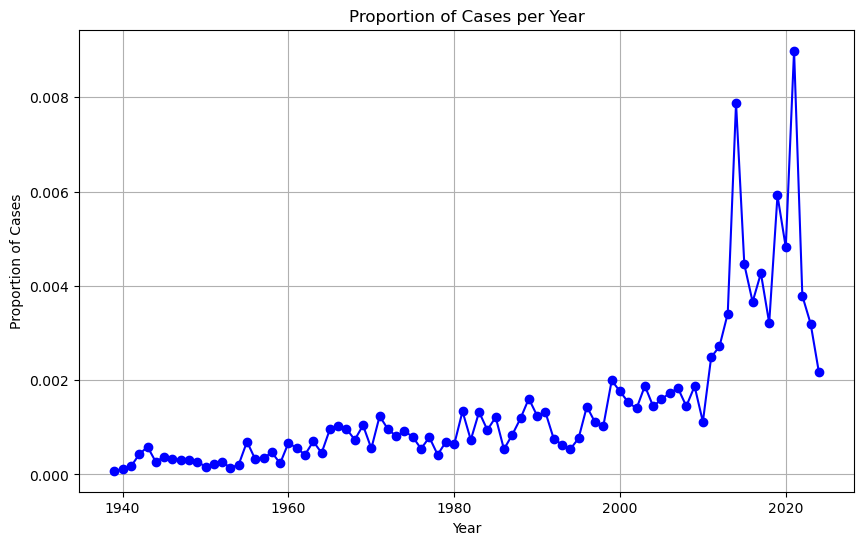

In [ ]:
# Step 2: Plot the results as a line graph
plt.figure(figsize=(10, 6))
plt.plot(proportion_per_year3.index, proportion_per_year3.values, marker='o', linestyle='-', color='b')
plt.title('Proportion of Cases per Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

Changes in df for merging

In [ ]:
econ_inequ_df = pd.read_csv('python_objects/congress39_econ_ineq_2401.csv')
#econ_inequ_df = pd.read_csv('python_objects/congress39_econ_ineq_0212_nyt_query.csv')
#econ_inequ_df = pd.read_csv('python_objects/congress39_econ_ineq_2911_new_query.csv')

In [ ]:
#Subset nyt query cases

speeches80_econ_inequ_window = econ_inequ_df[(econ_inequ_df["pattern_match_within_window"] == True) 
                                             & (econ_inequ_df["year"] > 1979)].reset_index(drop=True)

print("Congress as nyt query:", len(speeches80_econ_inequ_window))

#nyt query, 3777

Congress as nyt query: 3777


In [ ]:
speeches80_econ_inequ_window["party"].value_counts(normalize=True) * 100

Democrat       68.662252
Republican     31.178808
Independent     0.158940
Name: party, dtype: float64

In [ ]:
speeches80_econ_inequ_window["cleaned_tokens"].apply(len).mean()

9798.807254434736

In [ ]:
# Convert the column to datetime format
speeches80_econ_inequ_window["date"] = pd.to_datetime(speeches80_econ_inequ_window["date"], format="%Y-%m-%d")

# Format the column to DD-MM-YYYY
#speeches80_econ_inequ_window["date"] = speeches80_econ_inequ_window["date"].dt.strftime("%d-%m-%Y")

In [ ]:
#Columns required

# "speech_id": "id_" 
# text 
# party 
# "speaker": "author" 
# "date": "date_d-m-Y" 
# year

In [ ]:
congress80_merge = speeches80_econ_inequ_window[["speech_id", "text", 
                                                 "party", "speaker", 
                                                 "date", "year"]]

In [ ]:
congress80_merge.rename(columns={"speech_id": "id_", 
                                "speaker": "author",
                                "date": "date_d-m-Y"}, inplace=True)

In [ ]:
#Columns for merging: dataset, source

congress80_merge["dataset"] = "Congress"
congress80_merge["source"] = congress80_merge["party"]

C:\Users\agust\AppData\Local\Temp\ipykernel_29856\1555935699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress80_merge["dataset"] = "Congress"
C:\Users\agust\AppData\Local\Temp\ipykernel_29856\1555935699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress80_merge["source"] = congress80_merge["party"]


In [ ]:
congress80_merge.columns

Index(['id_', 'text', 'party', 'author', 'date_d-m-Y', 'year', 'dataset',
       'source'],
      dtype='object')

In [ ]:
congress80_merge.head()

,id_,text,party,author,date_d-m-Y,year,dataset,source
0,CREC-2015-01-06-pt1-PgH7-4-51,"Mr. Speaker, I thank my colleague. Mr. Speaker...",Democrat,Mr. VAN HOLLEN,2015-01-06,2015,Congress,Democrat
1,CREC-2015-01-08-pt1-PgH115-2-30,I thank the gentleman from California and the ...,Democrat,Ms. JACKSON LEE,2015-01-08,2015,Congress,Democrat
2,CREC-2015-01-12-pt1-PgS136-3-16,"Madam President, I rise today in opposition to...",Democrat,Mr. SCHATZ,2015-01-12,2015,Congress,Democrat
3,CREC-2015-01-13-pt1-PgH230-1,"Mr. Speaker, last week I spoke about Puerto Ri...",Democrat,Mr. PIERLUISI,2015-01-13,2015,Congress,Democrat
4,CREC-2015-01-21-pt1-PgH443-5-12,I want to thank my colleague for his great wor...,Democrat,Ms. SLAUGHTER,2015-01-21,2015,Congress,Democrat


In [ ]:
congress80_merge.to_csv('congress80_merge.csv', index=False)